<a href="https://colab.research.google.com/github/juanmed/uois/blob/master/uois_sample_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Test the IOUS network on the container unloading data
# Based on https://github.com/juanmed/uois/blob/master/uois_3D_example.ipynb

In [ ]:
# Clone repository here
!git clone https://github.com/juanmed/uois
!mv uois/* ./
!rm -rf uois

In [ ]:
# install dependencies
!pip install pypng matplotlib numpy opencv-python scikit-image gdown

In [4]:
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0" # TODO: Change this if you have more than 1 GPU

import sys
import json
from time import time
import glob

import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

# My libraries. Ugly hack to import from sister directory
import src.data_augmentation as data_augmentation
import src.segmentation as segmentation
import src.evaluation as evaluation
import src.util.utilities as util_
import src.util.flowlib as flowlib


Depth Seeding Network Parameters

In [5]:
dsn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal

    # Mean Shift parameters (for 3D voting)
    'max_GMS_iters' : 10, 
    'epsilon' : 0.05, # Connected Components parameter
    'sigma' : 0.02, # Gaussian bandwidth parameter
    'num_seeds' : 200, # Used for MeanShift, but not BlurringMeanShift
    'subsample_factor' : 5,
    
    # Misc
    'min_pixels_thresh' : 500,
    'tau' : 15.,
    
}

Region Refinement Network parameters

In [6]:
rrn_config = {
    
    # Sizes
    'feature_dim' : 64, # 32 would be normal
    'img_H' : 224,
    'img_W' : 224,
    
    # architecture parameters
    'use_coordconv' : False,
    
}

UOIS-Net-3D Parameters

In [7]:
uois3d_config = {
    
    # Padding for RGB Refinement Network
    'padding_percentage' : 0.25,
    
    # Open/Close Morphology for IMP (Initial Mask Processing) module
    'use_open_close_morphology' : True,
    'open_close_morphology_ksize' : 9,
    
    # Largest Connected Component for IMP module
    'use_largest_connected_component' : True,
    
}

Download weights for DSN and RRN and untar

In [8]:
# The weights are in a zip file here: https://drive.google.com/uc?export=download&id=1D-eaiOgFq_mg8OwbLXorgOB5lrxvmgQd
import gdown 
url = 'https://drive.google.com/uc?id=1D-eaiOgFq_mg8OwbLXorgOB5lrxvmgQd'
outfile = 'models.tar.gz'
gdown.download(url, outfile, quiet=False)
!mkdir models/
!tar xvf models.tar.gz --directory models/

Downloading...
From: https://drive.google.com/uc?id=1D-eaiOgFq_mg8OwbLXorgOB5lrxvmgQd
To: /content/models.tar.gz
100%|██████████| 254M/254M [00:02<00:00, 96.3MB/s]


DepthSeedingNetwork_3D_TOD_checkpoint.pth
RRN_OID_checkpoint.pth
RRN_TOD_checkpoint.pth


In [9]:
checkpoint_dir = '/content/models/' # TODO: change this to directory of downloaded models
dsn_filename = checkpoint_dir + 'DepthSeedingNetwork_3D_TOD_checkpoint.pth'
rrn_filename = checkpoint_dir + 'RRN_OID_checkpoint.pth'
uois3d_config['final_close_morphology'] = 'TableTop_v5' in rrn_filename
uois_net_3d = segmentation.UOISNet3D(uois3d_config, 
                                     dsn_filename,
                                     dsn_config,
                                     rrn_filename,
                                     rrn_config
                                    )

Let's use 1 GPUs for DSN!
Loaded DSNWrapper model
Let's use 1 GPUs for RRN!
Loaded RRNWrapper model


Run on example OSD/OCID images

In [10]:
example_images_dir = os.path.abspath('.') + '/example_images/'

OSD_image_files = sorted(glob.glob(example_images_dir + '/OSD_*.npy'))
OCID_image_files = sorted(glob.glob(example_images_dir + '/OCID_*.npy'))
N = len(OSD_image_files) + len(OCID_image_files)

rgb_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
xyz_imgs = np.zeros((N, 480, 640, 3), dtype=np.float32)
label_imgs = np.zeros((N, 480, 640), dtype=np.uint8)

for i, img_file in enumerate(OSD_image_files + OCID_image_files):
    d = np.load(img_file, allow_pickle=True, encoding='bytes').item()
    
    # RGB
    rgb_img = d['rgb']
    rgb_imgs[i] = data_augmentation.standardize_image(rgb_img)

    # XYZ
    xyz_imgs[i] = d['xyz']

    # Label
    label_imgs[i] = d['label']
    
batch = {
    'rgb' : data_augmentation.array_to_tensor(rgb_imgs),
    'xyz' : data_augmentation.array_to_tensor(xyz_imgs),
}

In [ ]:
print("Number of images: {0}".format(N))

### Compute segmentation masks ###
st_time = time()
fg_masks, center_offsets, initial_masks, seg_masks = uois_net_3d.run_on_batch(batch)
total_time = time() - st_time
print('Total time taken for Segmentation: {0} seconds'.format(round(total_time, 3)))
print('FPS: {0}'.format(round(N / total_time,3)))

# Get results in numpy
seg_masks = seg_masks.cpu().numpy()
fg_masks = fg_masks.cpu().numpy()
center_offsets = center_offsets.cpu().numpy().transpose(0,2,3,1)
initial_masks = initial_masks.cpu().numpy()

/content/src/evaluation.py:141: RuntimeWarning: invalid value encountered in double_scalars
  F[i,j] = (2 * prec * rec) / (prec + rec)


Image 1 Metrics:
{'Objects F-measure': 0.8691866140809872, 'Objects Precision': 0.8307766954055164, 'Objects Recall': 0.9113203684749233, 'Boundary F-measure': 0.7910418244928664, 'Boundary Precision': 0.729486699138254, 'Boundary Recall': 0.8639425235743152, 'obj_detected': 7, 'obj_detected_075': 6, 'obj_gt': 6, 'obj_detected_075_percentage': 1.0}
Image 2 Metrics:
{'Objects F-measure': 0.7640783027397547, 'Objects Precision': 0.7304398864705363, 'Objects Recall': 0.8009645395073266, 'Boundary F-measure': 0.6126108457517784, 'Boundary Precision': 0.6028952130284586, 'Boundary Recall': 0.6226447413497773, 'obj_detected': 20, 'obj_detected_075': 9, 'obj_gt': 15, 'obj_detected_075_percentage': 0.6}
Image 3 Metrics:
{'Objects F-measure': 0.7986086956521739, 'Objects Precision': 0.78591260031187, 'Objects Recall': 0.8117217268334839, 'Boundary F-measure': 0.7589762336998742, 'Boundary Precision': 0.8663366336633663, 'Boundary Recall': 0.6752910737386805, 'obj_detected': 8, 'obj_detected_075

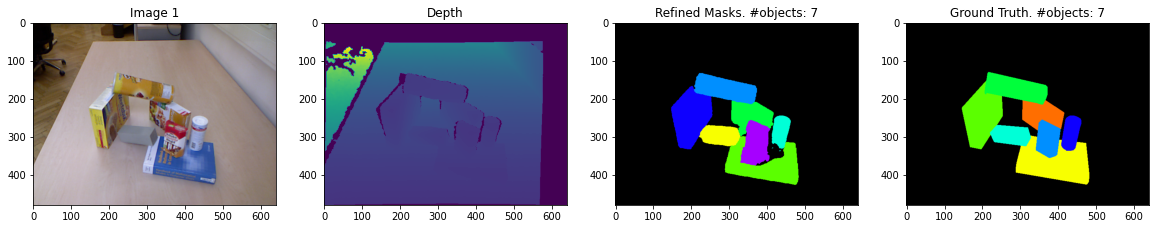

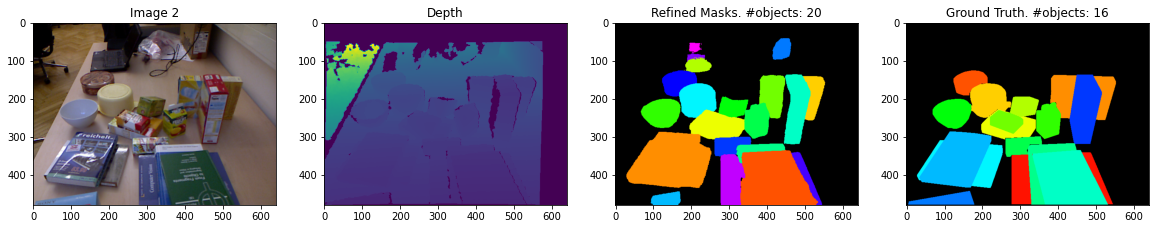

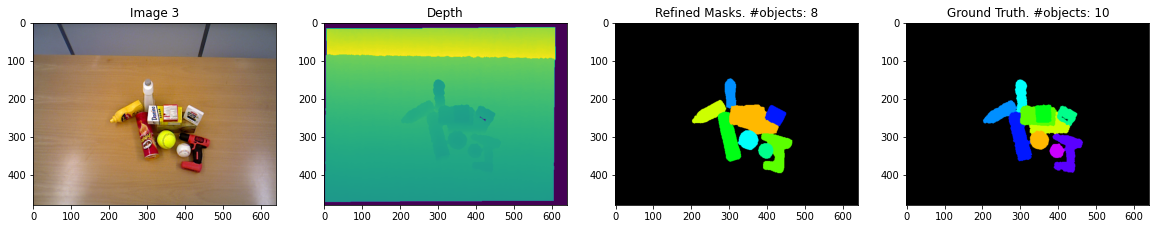

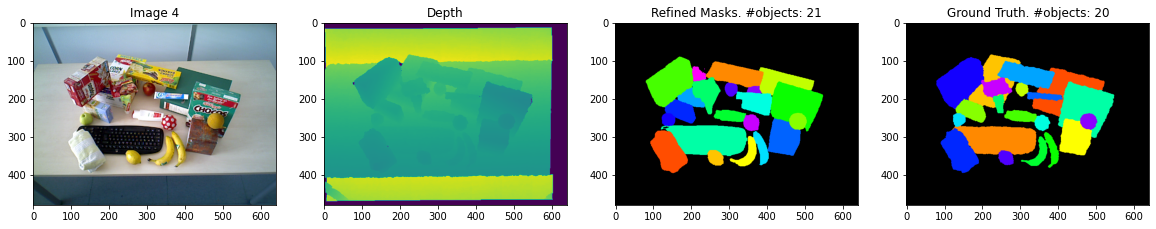

In [12]:
rgb_imgs = util_.torch_to_numpy(batch['rgb'].cpu(), is_standardized_image=True)
total_subplots = 6

fig_index = 1
for i in range(N):
    
    num_objs = max(np.unique(seg_masks[i,...]).max(), np.unique(label_imgs[i,...]).max()) + 1
    
    rgb = rgb_imgs[i].astype(np.uint8)
    depth = xyz_imgs[i,...,2]
    seg_mask_plot = util_.get_color_mask(seg_masks[i,...], nc=num_objs)
    gt_masks = util_.get_color_mask(label_imgs[i,...], nc=num_objs)
    
    images = [rgb, depth, seg_mask_plot, gt_masks]
    titles = [f'Image {i+1}', 'Depth',
              f"Refined Masks. #objects: {np.unique(seg_masks[i,...]).shape[0]-1}",
              f"Ground Truth. #objects: {np.unique(label_imgs[i,...]).shape[0]-1}"
             ]
    util_.subplotter(images, titles, fig_num=i+1)
    
    # Run evaluation metric
    eval_metrics = evaluation.multilabel_metrics(seg_masks[i,...], label_imgs[i])
    print(f"Image {i+1} Metrics:")
    print(eval_metrics)